In [10]:
import re
import numpy as np
import pandas as pd
from wombat.models import Item
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.externals import joblib
from wombat.models import dbsession, engine

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,10)
%matplotlib inline

# res = find_by_item_type("dresses")
query = """SELECT I.id, I.brand, I.item_type, I.cost,
    I.rent_per_week, I.year_purchased
    FROM items I"""
df = pd.read_sql_query(query, engine)

In [11]:
# Make a list of most frequent brands of the form 'BCBG', 'BCBGMAXAZRIA','Alice + Olivia', etc...
top_brands_query = "SELECT brand, count(brand) FROM items WHERE brand != 'LENDER SUBMISSION FILL IN' GROUP BY brand ORDER BY count(brand) DESC;"
top_brand_df = pd.read_sql_query(top_brands_query, engine)
top_brands = ["\'{}\'".format(brand.replace("'", "''")) for brand in top_brand_df['brand']]
top_brands = ', '.join(top_brands)

In [12]:
query = "SELECT brand, item_type, cost, rent_per_week FROM items WHERE brand in ({})".format(top_brands)
df = pd.read_sql_query(query, engine)

# get one-hot columns for brands 
dummy_bs = pd.get_dummies(df['brand'])
dummified_df = pd.concat([df, dummy_bs], axis = 1)
dummified_df = dummified_df.drop('brand', axis = 1)

# get one-hot columns for brands
dummified_items = pd.get_dummies(df['item_type'])
dummified_items = pd.concat([dummified_df, dummified_items], axis = 1)
df = dummified_items.drop('item_type', axis = 1)

In [23]:
# split data into train and test group
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
train, test = df[df['is_train']==True], df[df['is_train']==False]

print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:', len(test))

Number of observations in the training data: 4492
Number of observations in the test data: 1512


In [24]:
y = train['rent_per_week']
features = df.columns.drop('rent_per_week') # just column names

reg = linear_model.LinearRegression()
reg.fit(train[features], train['rent_per_week'])
#joblib.dump(reg, 'filename.pkl')
#call this with: clf = joblib.load('filename.pkl')


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

ValueError: Shape of passed values is (1, 1787), indices imply (1787, 1787)

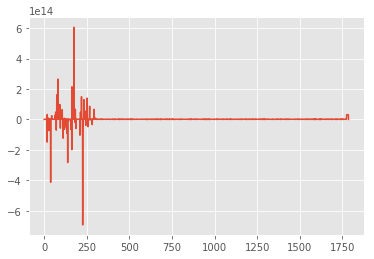

In [25]:
len(reg.coef_)
plt.plot(reg.coef_)
ser = pd.DataFrame(np.array(reg.coef_), columns = features)

In [26]:
test['predicted_rent'] = reg.predict(test[features])
def r2 (row):
   return row['predicted_rent'] - row['rent_per_week']
test['rent_difference'] = test.apply(lambda row: r2(row), axis=1)
reg.score(train[features], train['rent_per_week'])

/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.50774012309205907

In [9]:
clf = RandomForestRegressor()
clf.fit(train[features], train['rent_per_week'])

NameError: name 'RandomForestRegressor' is not defined

In [ ]:
rfr_pred = clf.predict(test[features]).astype(int)

In [27]:
#sklearn.metrics.confusion_matrix(test[features.drop('is_train')], rfr_pred)
test['predicted_rent'] = reg.predict(test[features])
def r2 (row):
   return row['predicted_rent'] - row['rent_per_week']
test['rent_difference'] = test.apply(lambda row: r2(row), axis=1)
df2 = test[features.drop('is_train')]
test['rent_difference']

/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


1       8.885753e+04
10     -1.310453e+03
13     -1.165028e+12
26      1.272168e+03
27     -1.165028e+12
29      9.175870e+04
33      8.290738e+03
37     -5.822116e+13
39      1.405738e+03
40     -9.917969e+00
42     -1.165028e+12
43     -1.165028e+12
44      1.593044e+04
56     -3.656055e+02
57     -7.990977e+02
60      7.289062e+01
63      5.113828e+02
64      6.558789e+02
68      8.587792e+04
69      8.660555e+04
81      8.663828e+03
83      5.589219e+03
84      2.430273e+03
88      4.329062e+02
89      5.151562e+02
95     -1.278143e+14
96      4.595738e+03
98      9.725562e+03
99     -4.731700e+04
101     5.196836e+02
            ...     
5889    1.432996e+03
5890    8.446681e+04
5891    1.447675e+04
5898    3.722109e+02
5899   -2.136723e+03
5903    1.580403e+04
5904    1.389577e+04
5906    2.521189e+04
5909    1.446175e+04
5910   -3.777930e+13
5914    1.767379e+04
5920   -1.165028e+12
5924   -2.521375e+03
5936    2.916322e+04
5939   -5.510766e+03
5940    8.406170e+04
5942   -4.668

In [28]:
# try random forest regression without dummifying variables first
# this ended up not working. It said, "Cannot convert string to float"
# which leads me to believe it was looking for a number instead of a category
# this means the original way of one-hoting the categories was correct.
df = pd.read_sql_query(query, engine)
# split data into train and test group
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
train, test = df[df['is_train']==True], df[df['is_train']==False]

print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:', len(test))

y = train['rent_per_week']
features = df.columns.drop('rent_per_week') # just column names

reg = linear_model.LinearRegression()
reg.fit(train[features], train['rent_per_week'])
rfr_predicted = reg.predict(test[features])

Number of observations in the training data: 4444
Number of observations in the test data: 1560


ValueError: could not convert string to float: 'dresses'

In [ ]:
from sklearn import linear_model

# Create linear regression object for predicted vs measured
reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(rfr_predicted)

# Train the model using the training sets
reg.fit(x, y)
# The coefficients
print('Coefficients: ', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(x, y))

# Plot outputs
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x = test['rent_per_week'], y = rfr_predicted)
#stopping_value = np.minimum(test['rent_per_week'].max, np.maximum(rfr_predicted))
stopping_value = 300
ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4)
ax.set_title('Errors for RFR with no adjectives')
ax.set_xlabel('Observed', fontsize=18)
ax.set_ylabel('Predicted', fontsize=18)
ax.plot(x, reg.predict(x), 'k--', color='blue', linewidth=3)

ax.text(0, -70, 'Coefficients: {}'.format(reg.coef_), style='italic', fontsize=16,
        bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})
ax.text(110, -70, "Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2), style='italic', fontsize=16,
        bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})
ax.text(220, -70, 'Variance score: %.2f' % reg.score(x, y), style='italic', fontsize=16,
        bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})

x = test['rent_per_week']
df_full_test['predicted_rent'] = rfr_predicted
df_full_test['error'] = df_full_test[['rent_per_week', 'predicted_rent']].sum(axis=1)
df_error = df_full_test.loc[df_full_test['error']>0][['brand', 'item_type', 'title', 'error', 'description']].sort_values('error', ascending = 0)